# Settings

In [ ]:
%%capture
!pip install osmnx geopandas geofeather

In [ ]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, Polygon
from shapely import  wkt
import pandas as pd
from scipy.spatial.distance import cdist
import operator
from geopandas import GeoDataFrame
from scipy.spatial import KDTree 
import os
import geofeather
from collections import deque
import re
import pickle
from scipy.spatial import distance


import warnings
warnings.filterwarnings('ignore')

from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
os.chdir("/content/gdrive")
os.getcwd()

'/content/gdrive'

In [ ]:
project_path = '/content/gdrive/MyDrive/Project Lab Smart Cities'

# Milano data

In [ ]:
try:
  os.chdir(os.path.join(project_path, 'DATI/COMPLETE' ))
  print(os.getcwd())
except:
  print(os.getcwd())

/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/COMPLETE


In [ ]:
def get_geofeather_Files(subFolder_name, file):
  focus = subFolder_name
  if os.getcwd() != os.path.join(project_path, f'DATI/COMPLETE/{focus}/Geofeather'): 
    os.chdir(os.path.join(project_path, f'DATI/COMPLETE/{focus}/Geofeather'))

  for ext in os.listdir(os.getcwd()):
    if str(ext) == file:
      return geofeather.from_geofeather(ext)


In [ ]:
milano_shape_dbt = gpd.GeoDataFrame(get_geofeather_Files("MILANO", 'base_dbt_per_pianificazione'))
milano_shape_dbt = milano_shape_dbt.to_crs("EPSG:4326")

milano_shape_dbt["codice_strato_tema" ] = pd.Series(list(map(lambda x: str(x).split("_", maxsplit=1)[0], milano_shape_dbt["codice_classe"]))).astype(int)
milano_shape_dbt["classe" ] = pd.Series(list(map(lambda x: str(x).split("_", maxsplit=1)[1], milano_shape_dbt["codice_classe"])))

df_leggero = milano_shape_dbt.explode(index_parts=False)
df_leggero.head(2)

,codice_classe,dataset,attributo,codice,descrizione,destinazione_indicativa,superficie_mq,codice_strato_tema,classe,geometry
0,020206_AATT,AATT,AATT_TY,06,spazio interno generico,area attrezzata,43,20206,AATT,"POLYGON ((9.27209 45.46244, 9.27207 45.46247, ..."
1,020206_AATT,AATT,AATT_TY,01,cortile,area attrezzata,3481,20206,AATT,"POLYGON ((9.25963 45.48442, 9.25972 45.48444, ..."


**DI NOSTRO INTERESSE**:

* AATT = 020206 Area attrezzata del suolo

* AC_CIC = 040101 Area bagnata di corso d'acqua
 
* ARGINE = 020502 Argine 

* AR_VRD = 060401 Area verde

* A_TRAS = 050304 = Area in trasformazione o non strutturata

* CL_AGR = 060106 Coltura agricola 

* EDIFC = 020102 Edificio

* INVASO = 040103 Invaso artificiale

* MU_DIV = 020210 Muro o divisione in spessore 

* PS_INC = 060105 Pascolo o incolto

* SP_ACQ = 040102 Specchio d'acqua


In [ ]:
residential = df_leggero[df_leggero.dataset == 'EDIFC_CR_EDF_IS']
residential.columns

Index(['codice_classe', 'dataset', 'attributo', 'codice', 'descrizione',
       'destinazione_indicativa', 'superficie_mq', 'codice_strato_tema',
       'classe', 'geometry'],
      dtype='object')

In [ ]:
residential['centroid_coord'] = residential['geometry'].apply(lambda x: x.centroid)
residential['centroid_lon'] = list(map(lambda p: p.x, residential['centroid_coord']))
residential['centroid_lat'] = list(map(lambda p: p.y, residential['centroid_coord']))

                  centroid_coord  centroid_lon  centroid_lat
341590  POINT (9.07855 45.46755)      9.078546     45.467553
341591  POINT (9.08574 45.46750)      9.085738     45.467500


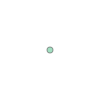

In [ ]:
print(residential.head(2)[['centroid_coord', 'centroid_lon','centroid_lat']])
type(residential.iloc[0].centroid_coord)
residential.iloc[0].centroid_coord

# Make Milan's streets and buildings graph:


1.   Make streets graph from a central point (hub) depending on walk or bike speed
2.   Identification of residential buildings within the graph
3. Construction of a sub-graph including only residential buildings and connecting roads
4. Identification of the potential hub node in the sub-graph
5. Calculation of buildings reachable in 15 minutes



In [ ]:
speed_mode = {'walk': 6, 'bike': 20}

In [ ]:
def graph_buildings_streets(hub_coord, mode):

  # Find bbox from max distance from hub (meters)
  dist = speed_mode[mode]*(1000/60)*15
  bbox = ox.utils_geo.bbox_from_point(point=(hub_coord.x, hub_coord.y), dist=dist)
  east, west, north, south = bbox

  # build streets graph
  streets = ox.graph_from_bbox(north=north, south=south, east=east, west=west, network_type=mode)
  
  print('Streets graph ready!')

  # buildings graph and DataFrame
  tags = {"building": True}
  buildings = ox.geometries_from_bbox(north = north, south = south, east = east, west = west, tags= tags)
  gdf_buildings = ox.project_gdf(buildings, to_crs = 'EPSG:4326')
 
  print('Buildings df ready!')

  # Snap the points to the nearest network nodes (consider only POINT geometry)
  # Explode MultiPolygon
  gdf_buildings = gpd.GeoDataFrame(gdf_buildings).explode(index_parts=False)


  # Compute point, polygon and multipolygon
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]
  
  # print(len(gdf_buildings_point), len(gdf_buildings_pol), len(gdf_buildings_mltpol))

  # Concat point dataframe to polygon centroid dataframe
  gdf_building_centroids = pd.DataFrame()
  gdf_building_centroids['osmid'] = gdf_buildings_pol.reset_index()['osmid']
  
  # print('\n', gdf_building_centroids.head(2))

  gdf_building_centroids['geometry'] = list(map(lambda x: x.centroid, list(gdf_buildings_pol['geometry'])))
  
  # print('\n', gdf_building_centroids.head(2))

  gdf_building_p = pd.concat([gdf_building_centroids, gdf_buildings_point], ignore_index=True)
  gdf_building_p['x'] = gdf_building_p.geometry.apply(lambda p: p.x) 
  gdf_building_p['y'] = gdf_building_p.geometry.apply(lambda p: p.y) 
  
  # print(gdf_building_p.head(2))

  # Build a GeoDataFrame
  gdf_buildings_crs = GeoDataFrame(gdf_building_p, crs="EPSG:4326", geometry=list(gdf_building_p.geometry))

  print('Buildings_centroids gdf ready!')


  # Function to find the node ID nearest to a given longitude and latitude
  # Prepare the coordinates array
  coordinates = list(map(lambda x: (x['x'], x['y']), list(map(operator.itemgetter(1), list(streets.nodes(data=True))))))
  nodes = ox.graph_to_gdfs(streets, nodes=True, edges=False).reset_index()
  nodes_ids = nodes.osmid.explode().tolist()
  edges = ox.graph_to_gdfs(streets, nodes=False, edges=True).reset_index()
  edges_ids = edges.osmid.explode().tolist()


  # Build a KD-tree spatial index
  tree = KDTree(coordinates)
  # print(tree)


  def find_nearest_edge_net(coord, tree=tree, nodes_ids=nodes_ids):
      
      # Calculate distances between target coordinates and graph nodes
      target_coordinates = (coord.x, coord.y)
      distances, indices = tree.query(target_coordinates, k=1)

    
      return nodes_ids[indices]


  # Find nearest_nodes
  point = list(gdf_buildings_crs.geometry)
  point.append(hub_coord)
  buildings_edges = list(map(find_nearest_edge_net, point))

  print('Buildings_nodes retrieved in streets graph!')

  ed = edges[(edges.u.isin(buildings_edges))|(edges.v.isin(buildings_edges))]
  ed_list = list(zip(ed.u.tolist(), ed.v.tolist(), ed.key.tolist()))

  milan_graph =  streets.edge_subgraph(ed_list)


  print('Milan graph ready!')

  return milan_graph

# Now you can find 15 minutes buildings

In [ ]:
def access_analysis(network, coord, mode, name, type_area, plot=False, save_gdf=False, max_minutes=15):

    # Function to find the node ID nearest to a given longitude and latitude
    # Prepare the coordinates array
    coordinates = list(map(lambda x: (x['x'], x['y']), list(map(operator.itemgetter(1), list(network.nodes(data=True))))))
    coordinates = [i for i in coordinates if i is not None]
    nodes = ox.graph_to_gdfs(network, nodes=True, edges=False).reset_index()
    nodes_ids = nodes.osmid.explode().tolist()

    # Build a KD-tree spatial index
    tree = KDTree(coordinates)

    def find_nearest_node_hub(coord, tree=tree, nodes_ids=nodes_ids):
        
        # Calculate distances between target coordinates and graph nodes
        target_coordinates = (coord.x, coord.y)
        distances, indices = tree.query(target_coordinates, k=1)

        nearest_node_id = nodes_ids[indices]

        return nearest_node_id
    
    node_hub = find_nearest_node_hub(coord=coord)
    # print(node_hub)

    nx.set_node_attributes(network, {node_hub:{'role': 'hub'}})

    # Function to find the node ID list nearest to a given longitude and latitude
    def find_near_nodes(network, start_node, mode, max_minutes):
        
        visited = set()
        queue = deque([(start_node, 0)])  # Tuple of (node, distance)

        max_distance = speed_mode[mode]*(1000/60)*max_minutes

        bfs_tree = nx.bfs_tree(network, source=start_node)

        # Print the nodes in BFS order
        visited = list(bfs_tree.nodes())

        return visited

    edges = ox.graph_to_gdfs(network, nodes=False, edges=True).reset_index()
    edges_ids = edges.osmid.explode().tolist()

    access = find_near_nodes(network, node_hub, mode, max_minutes)
    access.append(node_hub)
    
    ed = edges[(edges.u.isin(access))|(edges.v.isin(access))]
    ed_list = list(zip(ed.u.tolist(), ed.v.tolist(), ed.key.tolist()))

    # nodi vicino ad hub
    subG = network.subgraph(ed_list)

  
    if save_gdf:
      # Create a DataFrame for the nodes
      nodes_df = ox.graph_to_gdfs(network, nodes=True, edges=False).reset_index()[['osmid', 'x', 'y', 'role', 'geometry']]

      # Convert DataFrames to GeoDataFrames
      subG_gdf = gpd.GeoDataFrame(nodes_df)

      # Set the CRS for the GeoDataFrames
      subG_gdf.crs = 'EPSG:4326'
      
      subG_gdf.role.fillna('edif', inplace=True)

      subG_gdf.sort_values(by='role', ascending = False, inplace = True)
      subG_gdf.reset_index(inplace=True)
      subG_gdf.drop('index', axis = 1, inplace = True)

      # add distances
      # Compute euclidean distances
      hub_point = subG_gdf[subG_gdf.role=='hub'].iloc[0]
      edif = subG_gdf[subG_gdf.role!='hub']
      edif_points = edif.geometry.apply(lambda p: (p.x, p.y)).to_list() 

      # Calculate the pairwise distances between all points
      distances = distance.cdist([(hub_point.geometry.x, hub_point.geometry.y)], edif_points)[0].tolist()
      d = distances
      d.insert(0, 0)

      subG_gdf['distance hub'] = d

      subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')
      print('file saved')
    
    return 

# Find top 10 areas for each costructive hypothesis

In [ ]:
for type_area in ['renovation']:
  print(f'Folder: {type_area}')
  nanb = pd.read_csv(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/{type_area}_complete.csv', index_col=0)
  nanb.geometry = gpd.GeoSeries.from_wkt(nanb.geometry)
  potential_hub_coord = nanb.sort_values(by='area', ascending = False).head(10)
  potential_hub_coord['centroid'] = potential_hub_coord.geometry
  display(potential_hub_coord.head(20))
  
  csv = potential_hub_coord.copy()

  mode = 'walk'
  for i, hub_coord in enumerate(list(csv.centroid)):
    print(i)
    access_analysis(network=graph_buildings_streets(hub_coord, mode), coord=hub_coord,
                      mode=mode, type_area=type_area, name = f'{i}', plot=True, save_gdf=True)
  
  mode = 'bike'
  for i, hub_coord in enumerate(list(csv.centroid)):
    print(i)
    access_analysis(network=graph_buildings_streets(hub_coord, mode), coord=hub_coord,
                  mode=mode, type_area=type_area, name = f'{i}', plot=True, save_gdf=True)

Folder: renovation


,level_0,index,Cod_prog,INDIRIZZO,TIPO_MACRO,geometry,areaIndicator,geometry_buffered,buildings_geometry,area,volume,original_index,centroid
40,77,77,A421,VLE UMBRIA 126,PRODUTTIVO,POINT (9.21826 45.46145),"POLYGON ((9.217913715176405 45.46146448748419,...","POLYGON ((9.218268176260658 45.4614490370467, ...",/content/gdrive/MyDrive/Project Lab Smart Citi...,8841.130321,88411.303209,77,POINT (9.21826 45.46145)
99,170,170,A645,VIA PRIORATO 7,PRODUTTIVO,POINT (9.24292 45.47414),POLYGON ((9.243024769371399 45.473950686971406...,"POLYGON ((9.242932004920373 45.47413652614046,...",/content/gdrive/MyDrive/Project Lab Smart Citi...,8671.011172,86710.111719,170,POINT (9.24292 45.47414)
11,21,21,A268,VIA MEDICI DEL VASCELLO GIACOMO 14,PRODUTTIVO,POINT (9.23727 45.44313),"POLYGON ((9.236459508076011 45.44374168408931,...","POLYGON ((9.237279108855747 45.44313142053068,...",/content/gdrive/MyDrive/Project Lab Smart Citi...,7678.872935,76788.729348,21,POINT (9.23727 45.44313)
55,104,104,A476,VIA SAN FAUSTINO 62,INDUSTRIALE,POINT (9.24253 45.47608),"POLYGON ((9.243072965477005 45.47670207288618,...","POLYGON ((9.242542124658586 45.47607998313678,...",/content/gdrive/MyDrive/Project Lab Smart Citi...,7557.520507,75575.205075,104,POINT (9.24253 45.47608)
4,7,7,A196,VIA COSENZ ENRICO 63,PRODUTTIVO,POINT (9.16185 45.50644),"POLYGON ((9.161060526150184 45.50593615120012,...","POLYGON ((9.16185764676871 45.50644148634682, ...",/content/gdrive/MyDrive/Project Lab Smart Citi...,7282.448737,72824.487367,7,POINT (9.16185 45.50644)
39,76,76,A417,VIA GRAZZINI ANTON FRANCESCO 15,PRODUTTIVO,POINT (9.16041 45.50609),"POLYGON ((9.159849646573031 45.50612294943678,...",POLYGON ((9.160415425016453 45.506089227011465...,/content/gdrive/MyDrive/Project Lab Smart Citi...,6649.656310,66496.563102,76,POINT (9.16041 45.50609)
18,33,33,A115,CSO VENTIDUE MARZO 14,SPETTACOLO,POINT (9.21011 45.46190),"POLYGON ((9.209981095155625 45.46192282885896,...","POLYGON ((9.210116423079118 45.46189601179477,...",/content/gdrive/MyDrive/Project Lab Smart Citi...,6555.309893,65553.098930,33,POINT (9.21011 45.46190)
47,90,90,A450,VIA ANDOLFATO EZIO 12,INDUSTRIALE,POINT (9.22041 45.51568),"POLYGON ((9.22003519196921 45.51529280890848, ...",POLYGON ((9.220418347509609 45.515678990123206...,/content/gdrive/MyDrive/Project Lab Smart Citi...,6317.904247,63179.042472,90,POINT (9.22041 45.51568)
64,118,118,S508,VIA GRASSI GIOVANNI BATTISTA 93,INDUSTRIALE,POINT (9.11696 45.51892),"POLYGON ((9.116241254085693 45.51899246968683,...","POLYGON ((9.11697440758942 45.518921845068256,...",/content/gdrive/MyDrive/Project Lab Smart Citi...,6217.018391,62170.183913,118,POINT (9.11696 45.51892)
105,177,177,A652,VIA CONTE ROSSO 20,RESIDENZIALE,POINT (9.24282 45.48304),"POLYGON ((9.243051465975638 45.48307457705258,...","POLYGON ((9.24283345841311 45.483038430874984,...",/content/gdrive/MyDrive/Project Lab Smart Citi...,6080.574824,60805.748243,177,POINT (9.24282 45.48304)


0
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
1
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
2
Streets graph ready!
Buildings df ready!
Buildings_centroids gdf ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
3
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
4
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
5
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
6
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
7
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
8
Streets graph ready!
Buildings df ready!
Buildings_centroids gdf ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
9
Streets graph ready!
Buildings df ready!
Buildings_centroids gdf ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
0
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
1
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
2
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
3
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
4
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
5
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
6
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
7
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
8
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved
9
Streets graph ready!
Buildings df ready!


<ipython-input-13-f38c1ab47682>:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_point =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Point')].reset_index()[['osmid', 'geometry']]
<ipython-input-13-f38c1ab47682>:27: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_pol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'Polygon')]
<ipython-input-13-f38c1ab47682>:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  gdf_buildings_mltpol =  gdf_buildings[gdf_buildings['geometry'].apply(lambda geom: geom.type == 'MultiPolygon')]


Buildings_centroids gdf ready!
Buildings_nodes retrieved in streets graph!
Milan graph ready!


<ipython-input-14-8043be3ff120>:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subG_gdf.to_file(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/15Min_gdf_{mode}/15Min_{name}')


file saved


In [ ]:
for type_area in ['new_area_new_building', 'new_building']:
  print(f'Folder: {type_area}')
  nanb = pd.read_csv(f'/content/gdrive/MyDrive/Project Lab Smart Cities/DATI/FINAL/{type_area}/{type_area}RECTA.csv', index_col=0)
  nanb.final_geometry_rectangular = gpd.GeoSeries.from_wkt(nanb.final_geometry_rectangular)
  potential_hub_coord = nanb.sort_values(by='final_area_rectangular', ascending = False).head(10)
  potential_hub_coord['centroid'] = potential_hub_coord.final_geometry_rectangular.apply(lambda x: x.centroid)
  
  csv = potential_hub_coord.copy()

  mode = 'walk'
  for i, hub_coord in enumerate(list(csv.centroid)):
    print(i)
    access_analysis(network=graph_buildings_streets(hub_coord, mode), coord=hub_coord,
                      mode=mode, type_area=type_area, name = f'{i}', plot=True, save_gdf=True)
  
  mode = 'bike'
  for i, hub_coord in enumerate(list(csv.centroid)):
    print(i)
    access_analysis(network=graph_buildings_streets(hub_coord, mode), coord=hub_coord,
                  mode=mode, type_area=type_area, name = f'{i}', plot=True, save_gdf=True)